# Diabetes Prediction Case Study

## About Dataset
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.2
From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(broom)
library(leaps)
library(readr)
library(GGally)
library(pheatmap)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Data
This dataset contains 768 patient observations, each with 9 predictors related to diabetes risk factors:
- `Pregnancies`: Number of pregnancies
- `Glucose`: Glucose Level in Blood (in mg/dL)
- `BloodPressue`: Blood Pressure measurement (in mm Hg)
- `SkinThickness`: Thickness of skin (in mm)
- `Insulin`: Insulin Level in Blood
- `BMI`: Body Mass Index
- `DiabetesPedigreeFunction`: Likelihood of developing diabetes based on family history as percentage
- `Age`: Age of patient (in Years)
- `Outcome`: To express the final result 1 is Yes and 0 is No


## Question of Interest
Using this dataset, we aim to answer the question: What is the likelihood of a patient having diabetes based on key diagnostic factors?

The response variable for our analysis is the diabetes outcome (a binary variable indicating whether a patient has diabetes). The explanatory variables include medical predictors such as glucose levels, blood pressure, body mass index (BMI), age, insulin levels, and the diabetes pedigree function.

### How Data Will Help 
This dataset provides specific medical measurements for 768 patients, each labeled with an outcome for diabetes. By analyzing these measurements and fitting it to a logistic regression model, we can assess how strongly each predictor correlates with the likelihood of diabetes. This enables us to construct a model that predicts the probability of diabetes for a new patient based on their diagnostic measurements. 

### Focus: Prediction and Inference
- *Predict* the probability that a new patient has diabetes, based on the explanatory variables.
- *Infer* which variables are the most significant predictors of diabetes, providing insights into how specific health factors relate to diabetes risk.

In [2]:
path <- "./diabetes.csv"
diabetes <- read_csv(path)
head(diabetes)
tail(diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,89,62,0,0,22.5,0.142,33,0
10,101,76,48,180,32.9,0.171,63,0
2,122,70,27,0,36.8,0.340,27,0
5,121,72,23,112,26.2,0.245,30,0
1,126,60,0,0,30.1,0.349,47,1
1,93,70,31,0,30.4,0.315,23,0


## Exploratory Data Analysis

In [3]:
diabetes_data_pairplots <- diabetes |>
    ggpairs(progress = FALSE) +
    theme(
        text = element_text(size = 15),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )

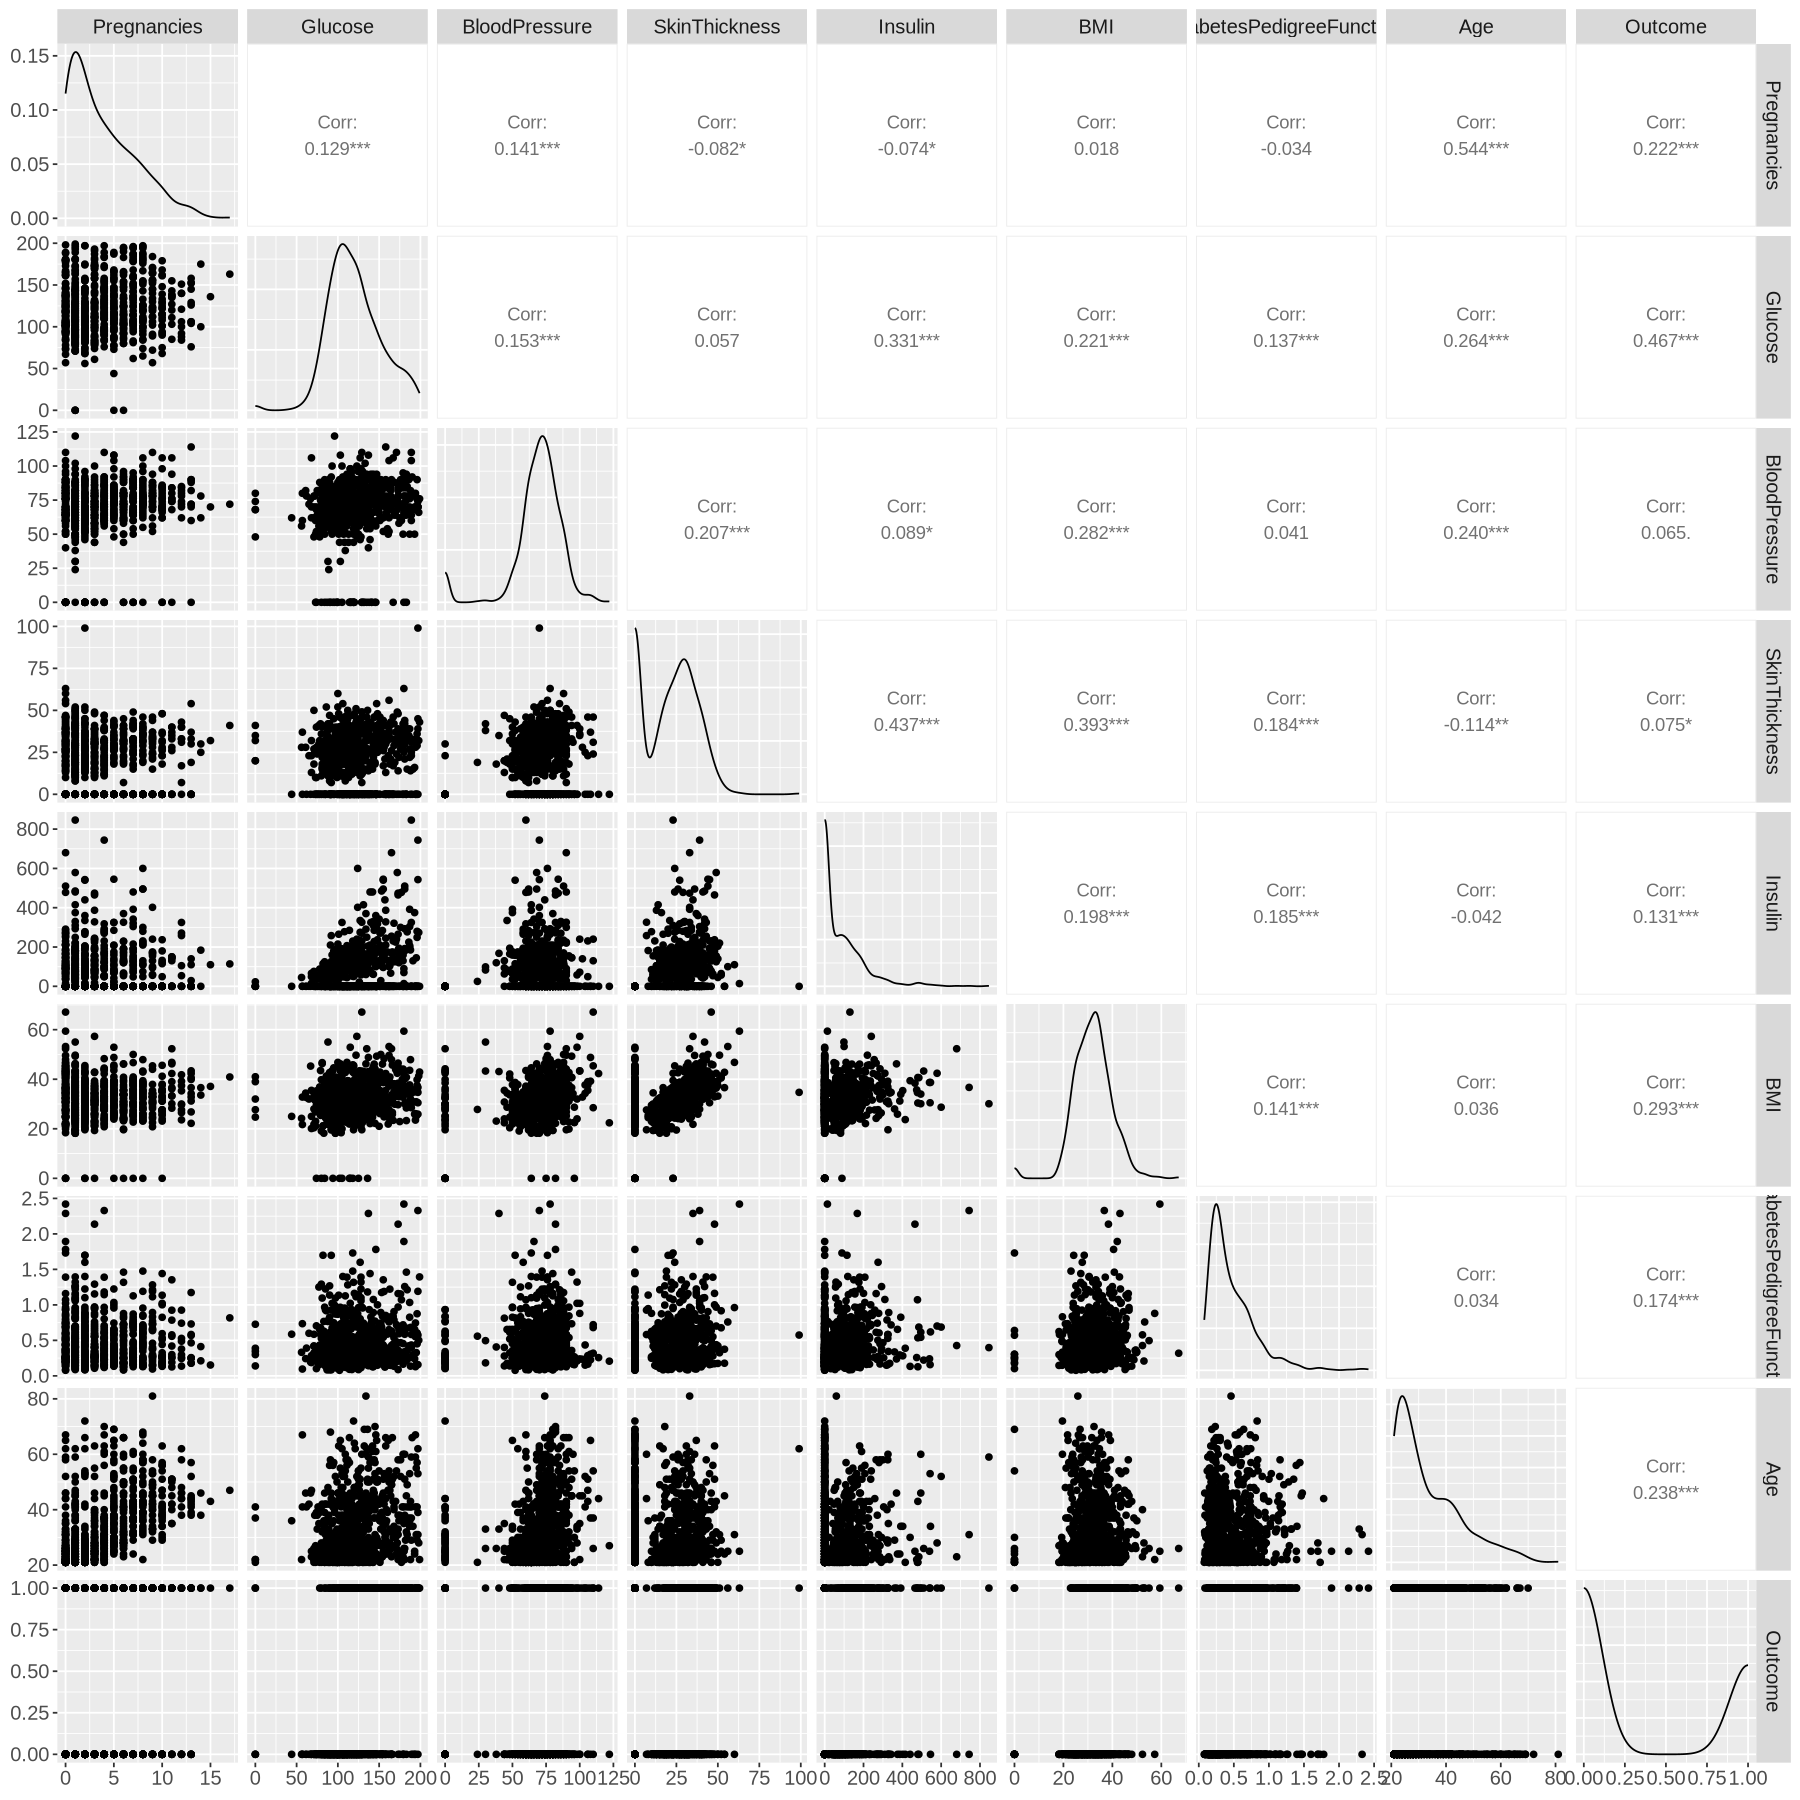

In [4]:
options(repr.plot.width = 15, repr.plot.height = 15)  # Adjust as needed
diabetes_data_pairplots

## Correlation Heatmap

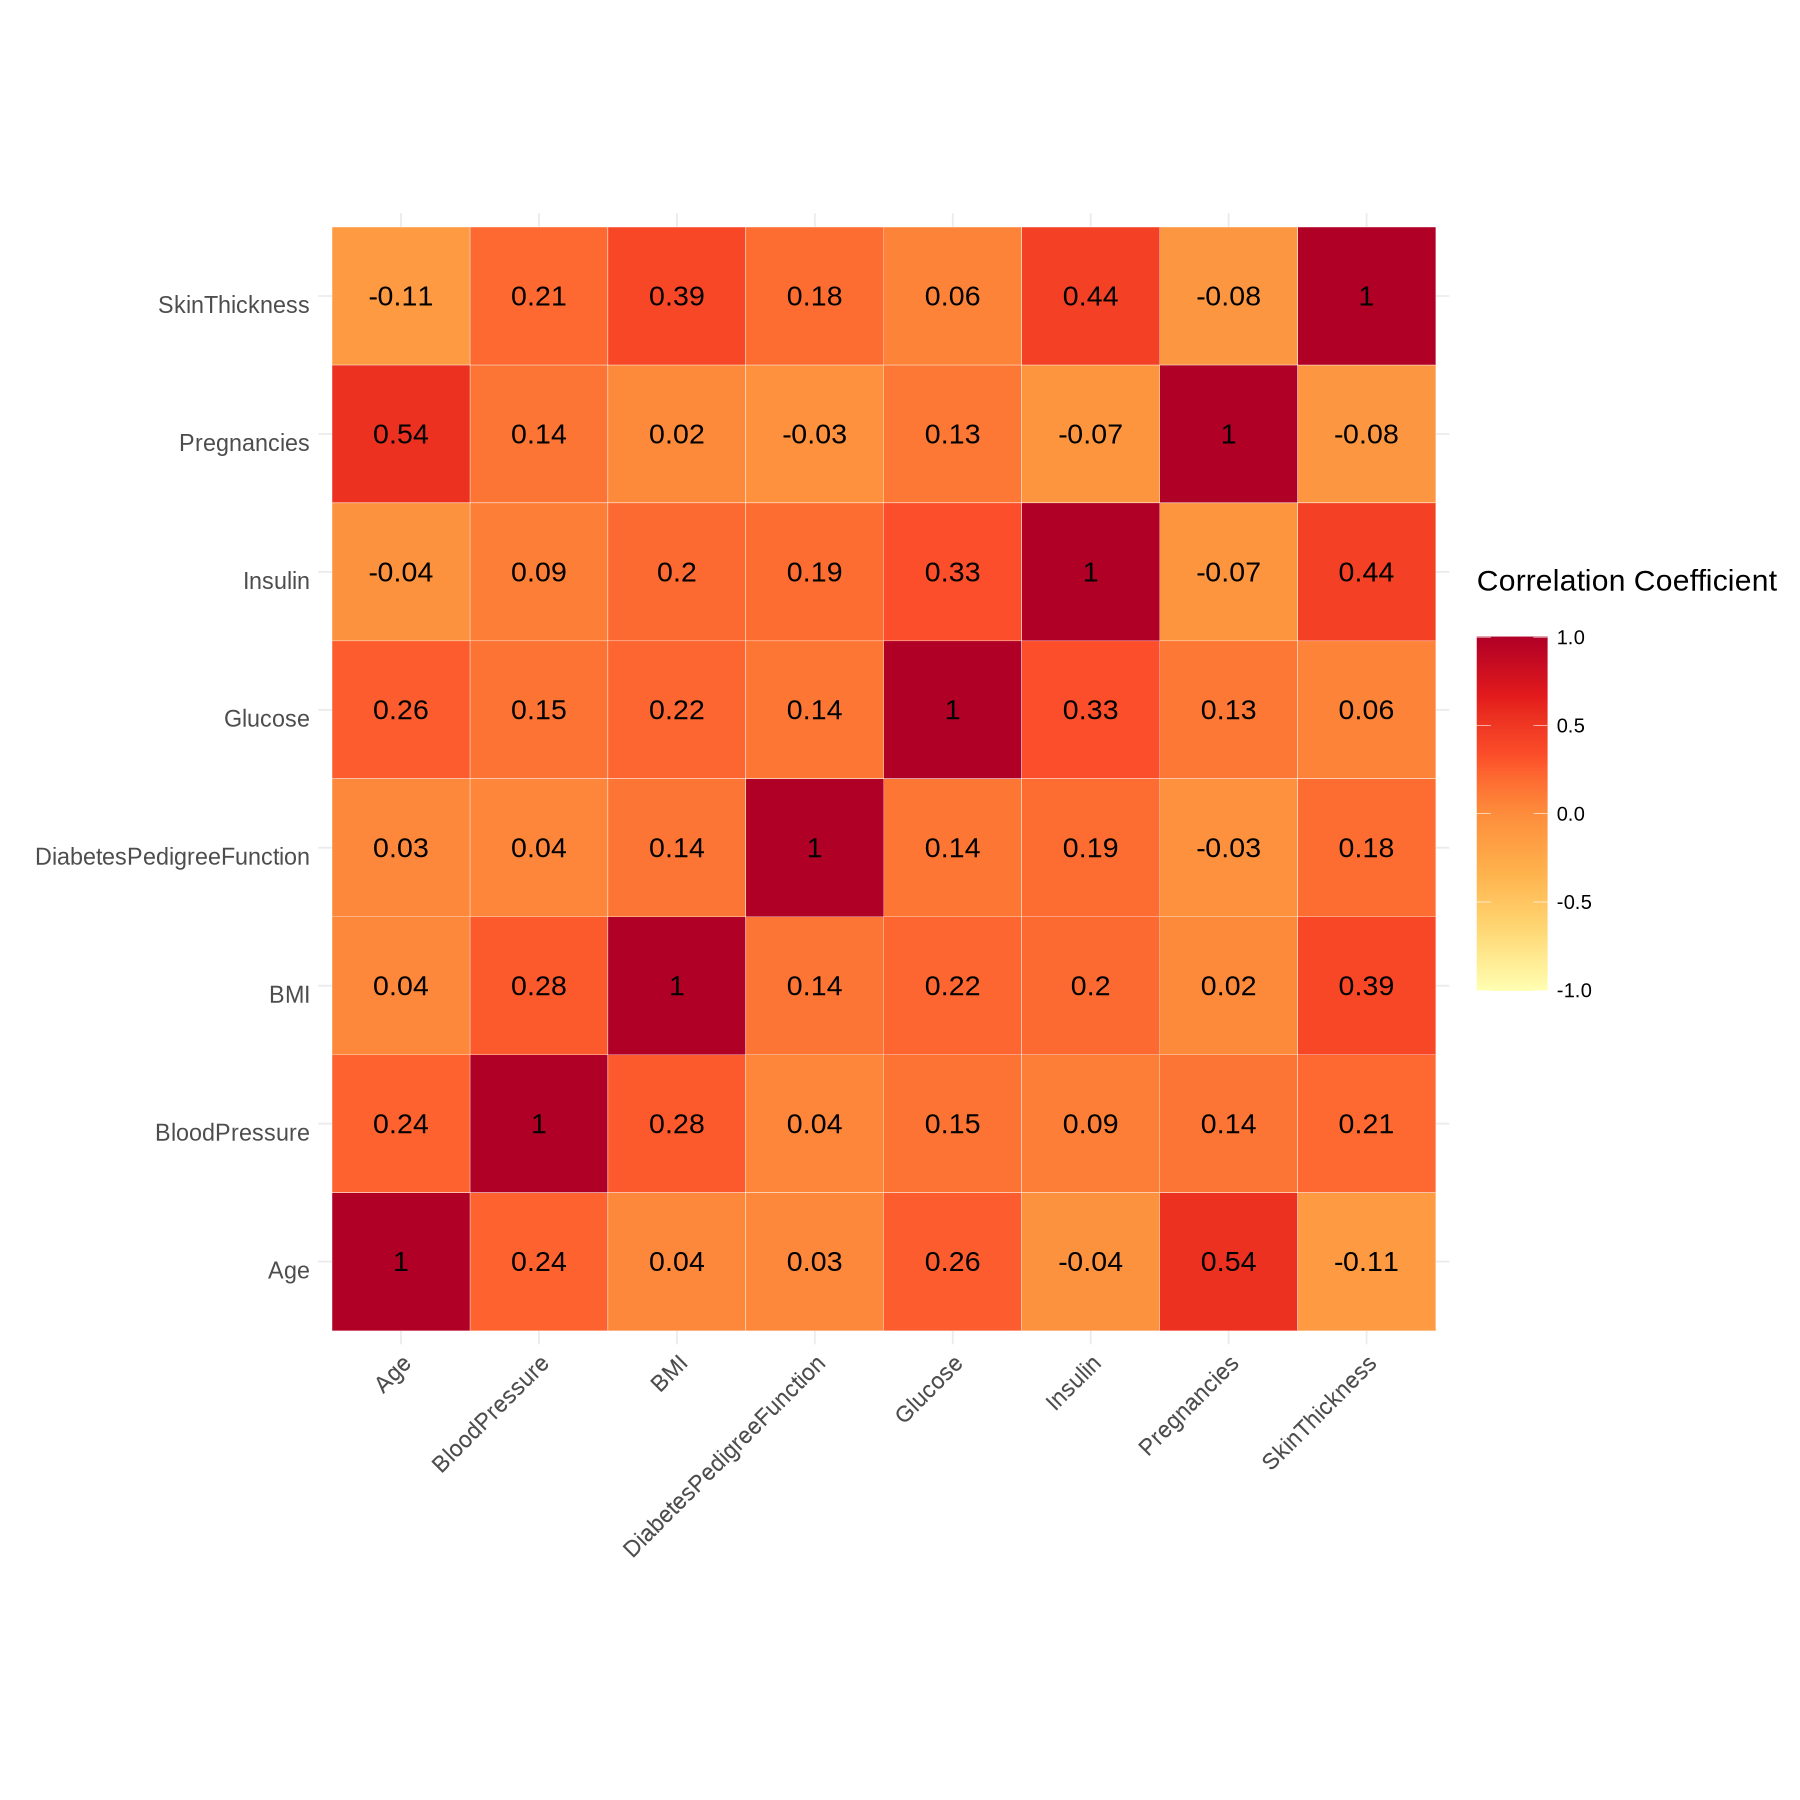

In [9]:
# cor_matrix <- cor(diabetes, use = "complete.obs")

corr_matrix <- 
   diabetes %>%
   select(- Outcome) %>% 
   cor() %>%
   as_tibble(rownames = 'var1') %>%
   pivot_longer(-var1, names_to = "var2", values_to = "corr")

plot_corr_matrix <- 
  corr_matrix %>%
  ggplot(aes(x = var1, y = var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
      palette =  "YlOrRd",
      direction = 1, 
      limits = c(-1,1)
    ) +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
  geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6)
plot_corr_matrix

From these pair plots we can see that Insulin and Gluscose levels have a strong positive relationship. 
Other predictors that stand out are the BMI and Skin thickness plots which also show a strong positive relationship.
BMI and Blood pressure also seem to have a slight positive correlation with each other.

These are the predictors we will focus on for this analysis.

## Splitting Data into Training and Testing Datasets

In [6]:
diabetes_split <- initial_split(diabetes, prop = 0.7, strata = Outcome)
training_diabetes <- training(diabetes_split)
testing_diabetes <- testing(diabetes_split)

## Visualizations